Import packages

In [1]:
import os
import chess
import chess.engine
import pandas as pd
import numpy as np
from plotting_functions import plot_heat_map, plot_samples
import itertools
import zentables

/var/folders/s3/06m5bv8s03v5c2y_thvlc6qr0000gp/T/ipykernel_2660/56717594.py:5: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(chess_data_fullfile, nrows=500000)


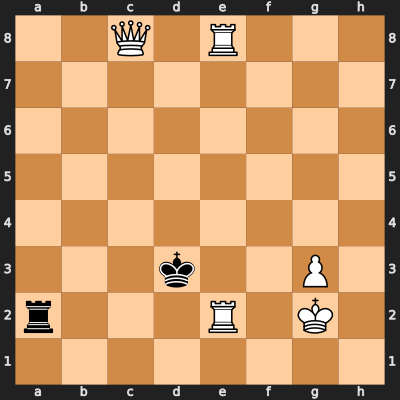

In [3]:
stockfish_path = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Chess_Engines/stockfish/15/bin/stockfish"
chess_data_folder = '/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Chess_Data'
chess_csv_file = 'lichess_db_standard_rated_2019-01.csv'
chess_data_fullfile = os.path.join(chess_data_folder,chess_csv_file)
data_raw = pd.read_csv(chess_data_fullfile, nrows=500000)
data_raw.head()

# what game types do we care about? filter dataframe to only include these time-control settings (these occur on first page) - new name for df is data_filt
game_time_types = ['600+0']

# filter based on if it's in these game settings... 
data_filt = data_raw.loc[data_raw.time_control.isin(game_time_types)].reset_index(drop = True)

def count_pieces(this_fen):
    
    n_pieces = 0
    for i in this_fen:
        if i == ' ':
            break
        
        if i.isalpha():
            n_pieces += 1
    
    return n_pieces

data_filt['n_pieces'] = data_filt.apply(lambda row : count_pieces(row['board']), axis = 1)

data_filt = data_filt.loc[data_filt.n_pieces == 7,:].reset_index(drop=True)

engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

data_idx = 11
this_row = data_filt.loc[data_idx,:]
this_fen = this_row.board
current_board = chess.Board(this_fen)
this_white_active = this_row.white_active
player_to_move = "white" if this_white_active else "black"
chess.svg.board(current_board, size = 400)

## Functions for Score processing

In [2]:
# for cp to wp
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cp_to_wp(score_val_cp_white):
    """
    Converts centipawn score val (signed with white pos/black neg) to win prob for white
    
    Args:
        score_val_cp_white: centipawn value (signed with white positive black negative) for position
    Returns:
        win probability: measure between 0 and 1 giving probability of white win
        Note: taken for logistic regression model applied to predict win given centipawn games
    """
    this_const = -0.045821224987387915;
    this_board_score_val = 0.002226678310106879
    #return sigmoid(log_reg_cp.params['const'] + log_reg_cp.params['board_score_val']*score_val_cp_white)
    return sigmoid(this_const + this_board_score_val*score_val_cp_white)

def mate_to_wp(score_val_mate):
    """
    Converts plys from mate to win prob (for the player who is within reach of mate)
    """
    # return sigmoid(log_reg_mate.params['const'] + log_reg_mate.params['score_val_pos']*np.abs(score_val_mate))
    return sigmoid(3.6986223572286208 + -0.05930670977061789*np.abs(score_val_mate))


# add support for if mate == 0!!!!!!!
def process_score(this_score, white_active):
    """
    Input:
    this score:  what is returned from stockfish
    white active: is whether it is white's move
    
    Output:
    score_dict: contains
    """
    
    white_score = this_score.white()
    is_mate = white_score.is_mate()
    
    if is_mate:
        score_type = 'mate'
        score_val = white_score.mate() # this is framed as white'
        if score_val > 0:
            wp = mate_to_wp(score_val) # this is framed as whichever side is close to mate
        elif score_val < 0:
            wp = 1 - mate_to_wp(score_val)
        elif score_val == 0:
            wp = 1 if white_active else 0
            # 1 or -1 depending on whose move this is.... so process score needs to take in who is active
    else: # centipawn...
        score_type = 'cp'
        score_val = white_score.score()
        wp = cp_to_wp(score_val)
    
    wp_active = wp if white_active else 1 - wp
        
    #score_dict = {'type': score_type, 'val': score_val, 'wp': wp}
    return wp_active


In [15]:
# so first part is to get set of pieces that can be removed to define each construal

# want to get every combination of keys we might remove
def findsubsets(s, n):
    return list(itertools.combinations(s, n))
    
def get_sets_of_pieces_for_removal(board):
    
    """
    Input: 
        board: chess.Board structure - the board we want to get construals for
    Output: 
        key_removal_subsets: list w/ entry for each possible construal, w/ keys removed (from full board) specified
        square_removal_subsets: same, but specifies squares w/ piece
    """

    # piece map is how python-chess represents the board - it's a dict w/ key and piece
    full_piece_map = board.piece_map()
    
    # Get eligible keys for removal - everything except for the king
    eligible_keys_for_removal = [key for key,val in full_piece_map.items() if ((val != chess.Piece.from_symbol('K')) & (val != chess.Piece.from_symbol('k')))]
    eligible_vals_for_removal = [val.symbol() for key,val in full_piece_map.items() if ((val != chess.Piece.from_symbol('K')) & (val != chess.Piece.from_symbol('k')))]
    eligible_squares_for_removal = [eligible_vals_for_removal[i]+chess.square_name(eligible_keys_for_removal[i]) for i in range(len(eligible_keys_for_removal))]

    # make all subsets of size X of keys that can be removed, with X = 0:n_eligible squares
    key_removal_subsets = []
    square_removal_subsets = []

    n_eligible_pieces_for_removal = len(eligible_squares_for_removal)
    for n in range(0,n_eligible_pieces_for_removal+1):
        key_removal_subsets.extend(findsubsets(eligible_keys_for_removal,n))
        these_subsets = findsubsets(eligible_squares_for_removal,n)
        square_removal_subsets.extend(these_subsets)

    return key_removal_subsets, square_removal_subsets

key_removal_subsets, square_removal_subsets = get_sets_of_pieces_for_removal(current_board)
square_removal_subsets

[(),
 ('Re8',),
 ('Qc8',),
 ('Pg3',),
 ('Re2',),
 ('ra2',),
 ('Re8', 'Qc8'),
 ('Re8', 'Pg3'),
 ('Re8', 'Re2'),
 ('Re8', 'ra2'),
 ('Qc8', 'Pg3'),
 ('Qc8', 'Re2'),
 ('Qc8', 'ra2'),
 ('Pg3', 'Re2'),
 ('Pg3', 'ra2'),
 ('Re2', 'ra2'),
 ('Re8', 'Qc8', 'Pg3'),
 ('Re8', 'Qc8', 'Re2'),
 ('Re8', 'Qc8', 'ra2'),
 ('Re8', 'Pg3', 'Re2'),
 ('Re8', 'Pg3', 'ra2'),
 ('Re8', 'Re2', 'ra2'),
 ('Qc8', 'Pg3', 'Re2'),
 ('Qc8', 'Pg3', 'ra2'),
 ('Qc8', 'Re2', 'ra2'),
 ('Pg3', 'Re2', 'ra2'),
 ('Re8', 'Qc8', 'Pg3', 'Re2'),
 ('Re8', 'Qc8', 'Pg3', 'ra2'),
 ('Re8', 'Qc8', 'Re2', 'ra2'),
 ('Re8', 'Pg3', 'Re2', 'ra2'),
 ('Qc8', 'Pg3', 'Re2', 'ra2'),
 ('Re8', 'Qc8', 'Pg3', 'Re2', 'ra2')]

### Get best move for each construal

In [21]:
def is_board_illegal(this_board, white_active):
    
    # check if removing pieces to create the construal placed the non-acting player in check 
    # - if so, this is an illegal board state
    
    check_board = this_board.copy()
    if white_active:
        check_board.turn == chess.BLACK
    else:
        check_board.turn = chess.WHITE
    
    return check_board.is_check()

def get_construal_selected_actions(board, key_removal_subsets, eval_depth = 12):
    
    # we'll return fens, number of pieces, selected action and pieces for each construal
    construal_fens = []
    construal_n_pieces = []
    construal_selected_actions = []
    construal_pieces = []

    # loop through sets of pieces to remove (E.g. construals)
    for removed_pieces in key_removal_subsets:
        
        # make a new board that is the new construal
        new_board = board.copy()

        new_piece_map = full_piece_map.copy()

        for piece in removed_pieces:
            del new_piece_map[piece]

        new_board.set_piece_map(new_piece_map)    

        # get the pieces in this construal
        this_construal_pieces = [val.symbol()+chess.square_name(key) for key,val in new_piece_map.items()]
        construal_pieces.append(this_construal_pieces)

        # save a fen of the construal
        construal_fens.append(new_board.fen())

        # get number of pieces in the construal
        construal_n_pieces.append(2 + n_eligible_pieces_for_removal - len(removed_pieces))

        # get selected move in the construal
        if is_board_illegal(new_board, this_white_active):
            new_best_move = "illegal_board"
        else:    
            engine.configure({"Clear Hash": None})
            info = engine.analyse(new_board, chess.engine.Limit(depth=eval_depth))
            new_best_move = info['pv'][0].uci()

        construal_selected_actions.append(new_best_move)

    construal_selected_actions = np.array(construal_selected_actions)
    
    return construal_selected_actions, construal_fens, construal_pieces, construal_n_pieces

In [22]:
construal_selected_actions, construal_fens, construal_pieces, construal_n_pieces = get_construal_selected_actions(current_board, key_removal_subsets, eval_depth = 5)

#### Evaluate each action selected in each construal


In [41]:
def evaluate_construal_actions(board, construal_selected_actions, eval_depth = 12):
    
    # get unique actions to evaluate
    unique_construal_selected_actions = np.unique(construal_selected_actions)

    action_scores_orig_format = {}
    action_scores_processed = {}
    
    # store whether the action is legal on the actual board
    construal_action_legal = np.zeros(len(construal_selected_actions),dtype=bool)

    # store benefits
    construal_benefits = np.zeros(len(construal_selected_actions))

    # loop through unique moves
    for this_move in unique_construal_selected_actions:

        if this_move == "illegal_board":
            legal_action = False
            processed_score = 0
        else:

            # for each construal selected action, push it onto the board
            new_board = current_board.copy()

            if new_board.is_legal(chess.Move.from_uci(this_move)):

                legal_action = True

                new_board.push_uci(this_move)

                # don't need to clear the hash?
                engine.configure({"Clear Hash": None})
                info = engine.analyse(new_board, chess.engine.Limit(depth=eval_depth-1))
                print(this_move)
                print(info['score'])
                action_scores_orig_format[this_move] = info['score']
                processed_score = process_score(info['score'], this_white_active)
            else:
                legal_action = False
                processed_score = 0

        action_scores_processed[this_move] = processed_score
        construal_benefits[construal_selected_actions == this_move] = processed_score
        construal_action_legal[construal_selected_actions == this_move] = legal_action
        
    action_loss = construal_benefits - construal_benefits[0]
    action_loss[~construal_action_legal] = np.nan
    
    return action_scores_processed, construal_benefits, construal_action_legal, action_loss

In [42]:
action_scores_processed, construal_benefits, construal_action_legal, construal_action_loss = evaluate_construal_actions(current_board, construal_selected_actions, eval_depth = 5)

a2a5
PovScore(Cp(+2657), WHITE)
a2e2
PovScore(Cp(+1876), WHITE)
d3d4
PovScore(Mate(+1), WHITE)


In [45]:
CP_strings = [' '.join(cp) for cp in construal_pieces]

res_df = pd.DataFrame({'construal': CP_strings, 'num_pieces': construal_n_pieces, 'action': construal_selected_actions, 'legal': construal_action_legal, 'value': construal_benefits, 'loss': construal_action_loss})
res_df.zen.pretty()

,construal,num_pieces,action,legal,value,loss
0,Re8 Qc8 Pg3 kd3 Kg2 Re2 ra2,7,a2e2,True,0.015806,0.000000
1,Qc8 Pg3 kd3 Kg2 Re2 ra2,6,a2e2,True,0.015806,0.000000
2,Re8 Pg3 kd3 Kg2 Re2 ra2,6,a2a5,True,0.002814,-0.012992
3,Re8 Qc8 kd3 Kg2 Re2 ra2,6,a2e2,True,0.015806,0.000000
4,Re8 Qc8 Pg3 kd3 Kg2 ra2,6,illegal_board,False,0.000000,nan
5,Re8 Qc8 Pg3 kd3 Kg2 Re2,6,d3d4,True,0.025598,0.009792
6,Pg3 kd3 Kg2 Re2 ra2,5,d3e2,False,0.000000,nan
7,Qc8 kd3 Kg2 Re2 ra2,5,a2e2,True,0.015806,0.000000
8,Qc8 Pg3 kd3 Kg2 ra2,5,illegal_board,False,0.000000,nan
9,Qc8 Pg3 kd3 Kg2 Re2,5,d3d4,True,0.025598,0.009792


In [36]:
# now, add something about blunders, etc. 

array([0.0158061 , 0.0158061 , 0.00281363, 0.0158061 , 0.        ,
       0.02559785, 0.        , 0.0158061 , 0.        , 0.02559785,
       0.0158061 , 0.        , 0.02559785, 0.        , 0.02559785,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02559785, 0.        , 0.        , 0.        ,
       0.02559785, 0.        , 0.        , 0.        , 0.02559785,
       0.        , 0.02559785])